In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/train.zip -d train_data
!unzip /content/drive/MyDrive/test_all.zip -d test_data

In [90]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import os
import natsort
from PIL import Image
from collections import Counter

In [91]:
device = torch.device("cuda")

In [92]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_name = self.total_imgs[idx]
        img_loc = os.path.join(self.main_dir, img_name)
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, img_name

In [93]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.ImageFolder("./train_data/train", transform=transform)
trainset_check = torchvision.datasets.ImageFolder("./train_data/train", transform=transform_test)
testset = CustomDataSet("./test_data/test_all", transform=transform_test)

classes = trainset.classes

trainset, validset = torch.utils.data.random_split(trainset, [78011, 10000], generator=torch.Generator().manual_seed(43))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=False)
trainset_check_loader = torch.utils.data.DataLoader(trainset_check, batch_size=batch_size, shuffle=True)


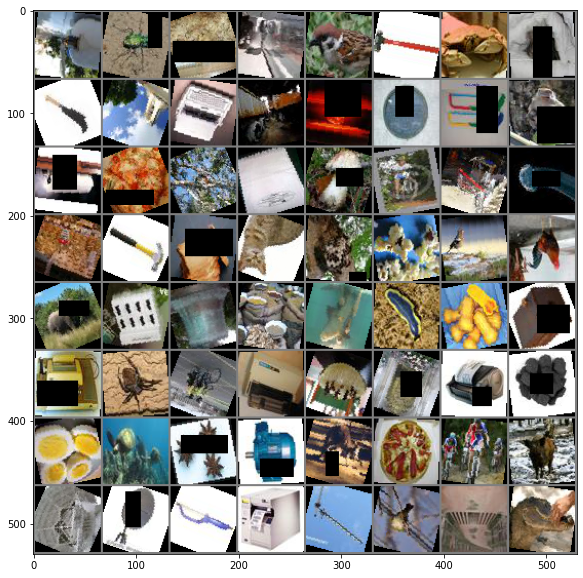

motor beetle  frog camera  bird hammer  crab   cat   saw acoustic printer truck  bomb memorial   saw monkey towel pizza monkey towel fungus bicycle bicycle  worm  crab hammer bread   cat  nest  corn  bird  bird elephant printer acoustic spice  fish  worm squash camera printer spider bicycle printer spice memorial printer carbon   egg turtle spice motor kangaroo pizza bicycle swine antenna antenna   saw printer antenna  bird bridge crocodilian


In [94]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

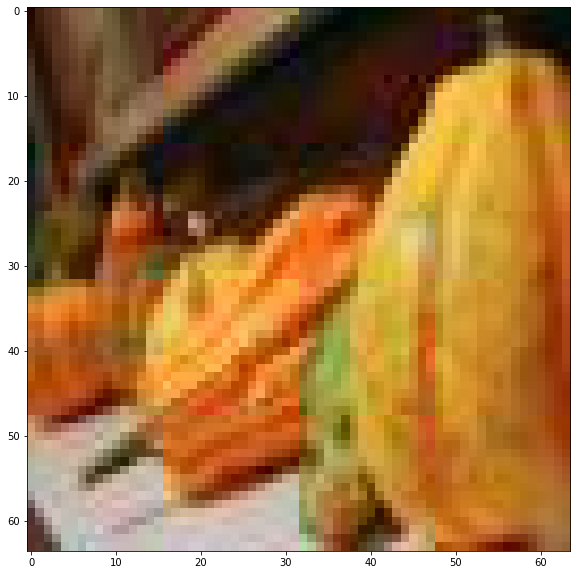

813799134952.JPEG


In [95]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

dataiter = iter(testloader)
images, name = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
print(name[0])

In [96]:
torch.cuda.empty_cache()

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1_conv = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2_conv = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=1)
        self.bn3_conv = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=1)
        self.bn4_conv = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(2048, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.d1 = nn.Dropout(0.4)        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.d2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.pool1(self.bn1_conv(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2_conv(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3_conv(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4_conv(F.relu(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.d1(F.relu(self.bn1(self.fc1(x))))
        x = self.d2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x


net = Net().to(device)

net

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_conv): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_conv): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3_conv): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4_conv): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, 

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 4, gamma = 0.7)
epoch_number = 30

In [ ]:
net.train()
prev_loss = 5

for epoch in range(epoch_number): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

    
    print(f'[%d/{epoch_number}] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    scheduler.step()
    running_loss = 0.0


print('Finished Training')

## Validation

### Validation Set


In [99]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
net.eval()
with torch.no_grad():
    for data in validloader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
all_accuracy = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    all_accuracy.append(accuracy)
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
    
print(sum(all_accuracy)/len(all_accuracy))

Accuracy for class acoustic is: 38.5 %
Accuracy for class antenna is: 50.7 %
Accuracy for class bacteria is: 68.8 %
Accuracy for class battery is: 51.6 %
Accuracy for class bean  is: 53.5 %
Accuracy for class beetle is: 75.0 %
Accuracy for class bicycle is: 75.3 %
Accuracy for class birch is: 59.3 %
Accuracy for class bird  is: 34.7 %
Accuracy for class bomb  is: 56.3 %
Accuracy for class bread is: 58.7 %
Accuracy for class bridge is: 63.5 %
Accuracy for class camera is: 71.6 %
Accuracy for class carbon is: 56.4 %
Accuracy for class cat   is: 61.9 %
Accuracy for class corn  is: 59.7 %
Accuracy for class crab  is: 42.6 %
Accuracy for class crocodilian is: 53.7 %
Accuracy for class echinoderm is: 53.6 %
Accuracy for class egg   is: 54.0 %
Accuracy for class elephant is: 76.7 %
Accuracy for class fish  is: 53.4 %
Accuracy for class flower is: 91.0 %
Accuracy for class frog  is: 49.0 %
Accuracy for class fungus is: 74.0 %
Accuracy for class gauge is: 60.3 %
Accuracy for class hammer is: 75

### Training Set


In [100]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
net.eval()
with torch.no_grad():
    for data in trainloader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu() 
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
all_accuracy = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    all_accuracy.append(accuracy)
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
    
print(sum(all_accuracy)/len(all_accuracy))

Accuracy for class acoustic is: 57.6 %
Accuracy for class antenna is: 57.5 %
Accuracy for class bacteria is: 75.5 %
Accuracy for class battery is: 59.4 %
Accuracy for class bean  is: 62.7 %
Accuracy for class beetle is: 77.2 %
Accuracy for class bicycle is: 83.4 %
Accuracy for class birch is: 68.6 %
Accuracy for class bird  is: 44.3 %
Accuracy for class bomb  is: 68.6 %
Accuracy for class bread is: 68.5 %
Accuracy for class bridge is: 72.9 %
Accuracy for class camera is: 76.8 %
Accuracy for class carbon is: 57.4 %
Accuracy for class cat   is: 68.9 %
Accuracy for class corn  is: 62.6 %
Accuracy for class crab  is: 53.1 %
Accuracy for class crocodilian is: 59.9 %
Accuracy for class echinoderm is: 60.3 %
Accuracy for class egg   is: 60.6 %
Accuracy for class elephant is: 80.3 %
Accuracy for class fish  is: 55.3 %
Accuracy for class flower is: 94.8 %
Accuracy for class frog  is: 55.2 %
Accuracy for class fungus is: 78.6 %
Accuracy for class gauge is: 66.6 %
Accuracy for class hammer is: 81

In [101]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
net.eval()
with torch.no_grad():
    for data in trainset_check_loader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu() 
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
all_accuracy = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    all_accuracy.append(accuracy)
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
    
print(sum(all_accuracy)/len(all_accuracy))

Accuracy for class acoustic is: 59.2 %
Accuracy for class antenna is: 63.2 %
Accuracy for class bacteria is: 76.9 %
Accuracy for class battery is: 69.0 %
Accuracy for class bean  is: 67.8 %
Accuracy for class beetle is: 81.9 %
Accuracy for class bicycle is: 86.1 %
Accuracy for class birch is: 73.6 %
Accuracy for class bird  is: 49.0 %
Accuracy for class bomb  is: 70.2 %
Accuracy for class bread is: 69.8 %
Accuracy for class bridge is: 77.7 %
Accuracy for class camera is: 82.1 %
Accuracy for class carbon is: 61.8 %
Accuracy for class cat   is: 74.2 %
Accuracy for class corn  is: 62.0 %
Accuracy for class crab  is: 54.5 %
Accuracy for class crocodilian is: 63.1 %
Accuracy for class echinoderm is: 67.4 %
Accuracy for class egg   is: 68.0 %
Accuracy for class elephant is: 84.6 %
Accuracy for class fish  is: 58.5 %
Accuracy for class flower is: 95.2 %
Accuracy for class frog  is: 62.7 %
Accuracy for class fungus is: 81.7 %
Accuracy for class gauge is: 70.4 %
Accuracy for class hammer is: 83

In [ ]:
preds = []

net.eval()
with torch.no_grad():
    for data in testloader:
        image, name = data    
        image = image.to(device)
        output = net(image).cpu() 
        _, prediction= torch.max(output, 1)
        preds.append([name[0], prediction.item()])

In [103]:
from google.colab import files
preds = pd.DataFrame(preds)
preds.to_csv('piatek_Krakowski_Pytlewski.csv', index = False, header = False)

files.download('piatek_Krakowski_Pytlewski.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>